<a href="https://colab.research.google.com/github/anupam3693/eip2/blob/master/Anupam_Kumar_EIP2_Batch2_Assignment_DNST_CIFAR10_AUG_exp2_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://keras.io/
# !pip install -q keras 
# import keras 
# print(keras.__version__)

In [0]:
import keras
import time
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Hyperparameters
# batch_size = 32
# num_classes =  10
# epochs = 50
# l = 40
# num_filter = 10
# compression = 0.5
# dropout_rate = 0

batch_size = 64
num_classes =  10
epochs = 200
l = 14
num_filter = 20
compression = 0.9
dropout_rate = 0.2


In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [0]:
# Dense Block
def add_denseblock(input, num_filter, dropout_rate):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

# Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate=0.2)
output = output_layer(Third_Transition)


In [0]:
model = Model(inputs=[input], outputs=[output])
# model.load_weights('DNST_model_weights_v6_5.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 32, 32, 20)   540         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 32, 32, 20)   80          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 32, 32, 20)   0           batch_normalization_47[0][0]     
__________________________________________________________________________________________________
conv2d_48 

In [0]:
# ak - block 3 learning rate

from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

            
clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=0.1, max_lr=0.3,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')


earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.5, patience=100, verbose=1,mode='min')


In [0]:
# determine Loss function and Optimizer
# decay=10e-4,momentum=0.9
sgd = SGD(decay=10e-4,momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
# ak - block 4 - image aug

# we can compare the performance with or without data augmentation
data_augmentation = True
callbacks_list=[clr,earlystopper]

start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=callbacks_list
        )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=2*(x_train.shape[0]//batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks_list
                       )

end = time.time()


Using real-time data augmentation.
Epoch 1/200
   3/1562 [..............................] - ETA: 50:08 - loss: 2.4828 - acc: 0.0938  

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112095). Check your callbacks.
  % delta_t_median)


1562/1562 [==============================] - 169s 108ms/step - loss: 1.3766 - acc: 0.4978 - val_loss: 1.5768 - val_acc: 0.5614
Epoch 2/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.9242 - acc: 0.6715 - val_loss: 0.9718 - val_acc: 0.6975
Epoch 3/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.7146 - acc: 0.7496 - val_loss: 0.7881 - val_acc: 0.7596
Epoch 4/200
1562/1562 [==============================] - 162s 104ms/step - loss: 0.6719 - acc: 0.7648 - val_loss: 0.8145 - val_acc: 0.7579
Epoch 5/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.5982 - acc: 0.7923 - val_loss: 0.8020 - val_acc: 0.7657
Epoch 6/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.5276 - acc: 0.8176 - val_loss: 0.6271 - val_acc: 0.8111
Epoch 7/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.5003 - acc: 0.8274 - val_loss: 0.6912 - val_acc: 0.7965
Epoch 8/200
1562/1562 [================

1562/1562 [==============================] - 163s 104ms/step - loss: 0.1417 - acc: 0.9497 - val_loss: 0.4213 - val_acc: 0.9034
Epoch 60/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.1547 - acc: 0.9450 - val_loss: 0.4899 - val_acc: 0.8878
Epoch 61/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.1680 - acc: 0.9406 - val_loss: 0.4674 - val_acc: 0.8945
Epoch 62/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.1478 - acc: 0.9476 - val_loss: 0.5168 - val_acc: 0.8878
Epoch 63/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.1927 - acc: 0.9314 - val_loss: 0.4949 - val_acc: 0.8797
Epoch 64/200
1562/1562 [==============================] - 163s 104ms/step - loss: 0.1688 - acc: 0.9404 - val_loss: 0.4029 - val_acc: 0.9036
Epoch 65/200
1562/1562 [==============================] - 162s 104ms/step - loss: 0.1459 - acc: 0.9480 - val_loss: 0.4492 - val_acc: 0.8981
Epoch 66/200
1562/1562 [=========

1562/1562 [==============================] - 163s 104ms/step - loss: 0.1018 - acc: 0.9636 - val_loss: 0.4176 - val_acc: 0.9142
Epoch 118/200
1562/1562 [==============================] - 162s 104ms/step - loss: 0.0888 - acc: 0.9687 - val_loss: 0.4309 - val_acc: 0.9134
Epoch 00118: early stopping


Model took 5.34 hours to train


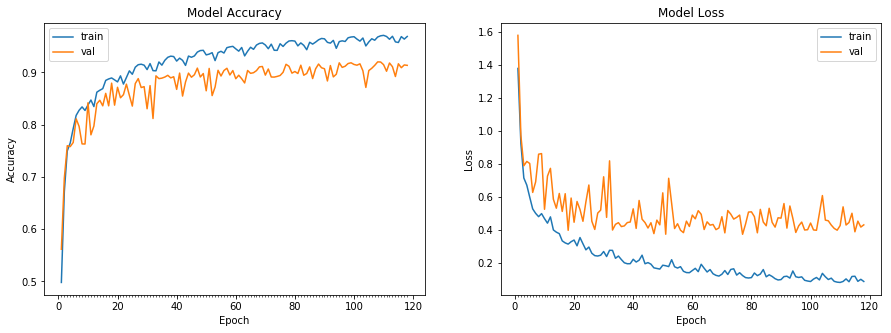

In [0]:
print ("Model took %0.2f hours to train"%((end - start)/3600))

plot_model_history(model_info)

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 525us/step
Test loss: 0.4309173761647195
Test accuracy: 0.9134


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_weights_s2_v1.h5")
print("Saved model to disk")

Saved model to disk
